In [ ]:
import re
import os
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

<h3>1. Preparing Data</h3>

In [ ]:
!rm -rf processed_data_final.csv
!cp ./drive/MyDrive/gdrive/RecruitResturantCaseStudy/processeddata/processed_data_final.csv .
data = pd.read_csv('processed_data_final.csv')
data.fillna(0,inplace=True)
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count,hour_diff_lt_12,hour_diff_bt_12_36,hour_diff_bt_36_59,hour_diff_bt_59_85,hour_diff_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday,avg_temperature,low_temperature,high_temperature,precipitation,visit_day,visit_month,visit_year,visit_week,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,m12_log1p,mean_visitors_cap_air_store_id_non_working,median_visitors_cap_air_store_id_non_working,min_visitors_cap_air_store_id_non_working,max_visitors_cap_air_store_id_non_working,count_visitors_cap_air_store_id_non_working,mean_visitors_cap_air_store_id_dow,median_visitors_cap_air_store_id_dow,min_visitors_cap_air_store_id_dow,max_visitors_cap_air_store_id_dow,count_visitors_cap_air_store_id_dow,mean_visitors_cap_air_store_id,median_visitors_cap_air_store_id,min_visitors_cap_air_store_id,max_visitors_cap_air_store_id,count_visitors_cap_air_store_id,mean_visitors_cap_log1p_air_store_id_non_working,median_visitors_cap_log1p_air_store_id_non_working,min_visitors_log1p_cap_air_store_id_non_working,max_visitors_cap_log1p_air_store_id_non_working,count_visitors_cap_log1p_air_store_id_non_working,mean_visitors_cap_log1p_air_store_id_dow,median_visitors_cap_log1p_air_store_id_dow,min_visitors_cap_log1p_air_store_id_dow,max_visitors_cap_log1p_air_store_id_dow,count_visitors_cap_log1p_air_store_id_dow,mean_visitors_cap_log1p_air_store_id,median_visitors_cap_log1p_air_store_id,min_visitors_cap_log1p_air_store_id,max_visitors_cap_log1p_air_store_id,count_visitors_cap_log1p_air_store_id,area_prefecture,area_sub_prefecture,open_resturant_count,reservation_count,lat+long,lat_max_diff,long_max_diff,distace_to_center,count_of_stores
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4,0.0,0.693147,0.0,0.0,0.0,Friday,0,0,0.0,1.0,25.6,22.0,30.6,0.0,1,7,2016,26,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,3.230017,25.156682,27.0,0.0,57.00,217,32.444444,35.0,0.0,57.00,45,22.198339,23.0,0.0,63.75,271,2.928279,3.332205,0.0,4.060443,217,3.195653,3.583519,0.0,4.060443,45,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.693147,175.447598,8.326629,4.519803,0.02744,271
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4,0.0,0.000000,0.0,0.0,0.0,Saturday,0,1,0.0,1.0,27.0,23.4,31.8,0.0,2,7,2016,26,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,3.230017,10.310185,7.0,0.0,63.75,54,12.412791,9.0,0.0,63.75,43,22.198339,23.0,0.0,63.75,271,1.832758,2.079442,0.0,4.170534,54,2.204169,2.302585,0.0,4.170534,43,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.000000,175.447598,8.326629,4.519803,0.02744,271
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4,0.0,0.000000,0.0,0.0,0.0,Monday,0,0,1.0,0.0,27.8,23.6,33.8,1.5,4,7,2016,27,25.869565,29.652174,29.384615,18.846154,0.0,0.0,26.08,24.166667,22.833333,...,3.230017,25.156682,27.0,0.0,57.00,217,19.170732,18.0,0.0,47.00,41,22.198339,23.0,0.0,63.75,271,2.928279,3.332205,0.0,4.060443,217,2.609416,2.944439,0.0,3.871201,41,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,794.0,0.000000,175.447598,8.326629,4.519803,0.02744,271


In [ ]:
data.visit_date = pd.to_datetime(data.visit_date)
data.set_index('visit_date', inplace=True)

train = data.loc[data.is_train == True, :]
test = data.loc[data.is_train == False, :]

to_drop = ['air_store_id', 'is_train', 'visitors_capped', 'visitors_log1p', 'visitors', 'air_area_name']

train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# fix the column names containing special characters
train = train.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', str(x)))
test = test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', str(x)))

<h3>2. Feature Selection by Recursive Feature Elimination</h3>

In [ ]:
from sklearn.feature_selection import RFECV, RFE
import xgboost as xgb


model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_jobs=-1)

# Instantiate RFECV visualizer with a XGBRegressor with step=5
rank_features = RFECV(model, step=10, scoring=rmsle_scorer, n_jobs=4, verbose=2)
rank_features.fit(train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name','distace_to_center','count_of_stores'],
                             axis=1).values, train['visitors_capped_log1p'].values.reshape(-1))

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


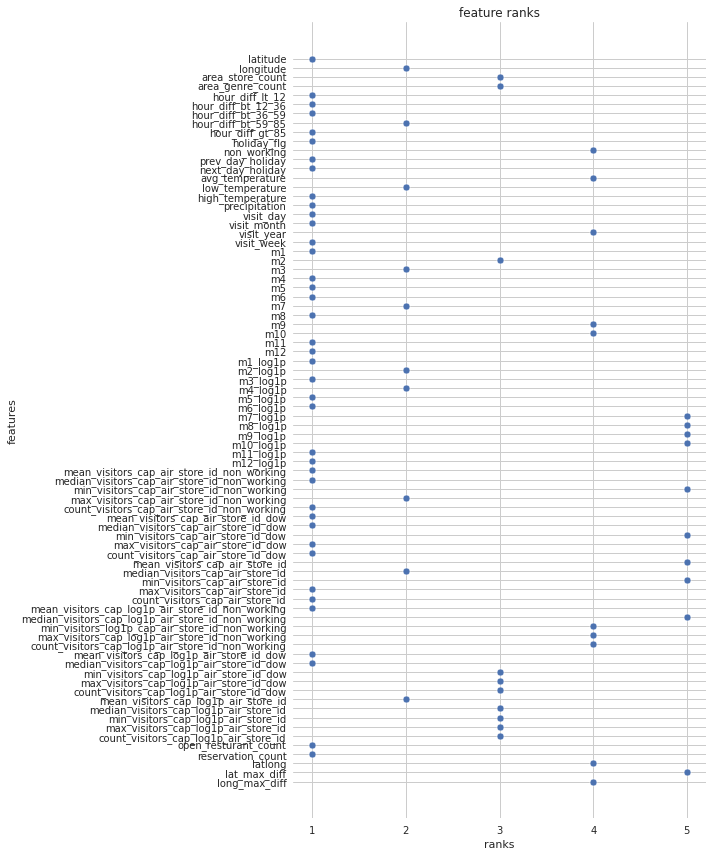

In [ ]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)

sns.scatterplot(rank_features.ranking_, train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', \
                                                    'air_genre_name','distace_to_center','count_of_stores'], axis=1).columns, ax=ax)
plt.xticks(range(1,6))
plt.xlabel('ranks')
plt.ylabel("features")
plt.title("feature ranks")
plt.tight_layout()
plt.show()

In [ ]:
# features with rank 1
selected_features = [feature for index, feature in enumerate(train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name','distace_to_center','count_of_stores'],
                             axis=1).columns) if rank_features.support_[index]]
print("No of selected features: ", len(selected_features))

No of selected features:  40


In [ ]:

selected_features.extend(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'])

x_train = train.loc[:, selected_features]
x_test = test.loc[:, selected_features]

In [ ]:
x_train = pd.get_dummies(x_train, columns=['day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'])
x_test =  pd.get_dummies(x_test, columns=['day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'])

In [ ]:
print("No of features:", x_train.shape[1])
print("train data size: ", x_train.shape)
print("test data size: ", x_test.shape)

No of features: 126
train data size:  (252108, 126)
test data size:  (32019, 126)


In [ ]:
x_train.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/processeddata/x_train.csv',index=False)
x_test.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/processeddata/x_test.csv',index=False)

<h2>3. Divide Data into Train and Validation </h2>

In [ ]:
x_train=pd.read_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/processeddata/x_train.csv')
x_train.index=train.index
x_test=pd.read_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/processeddata/x_test.csv')
x_test.index=test.index

In [ ]:
# training : 2016-01-01 to 2017-03-31 = 15 months
X_train = x_train.loc[x_train.index <= pd.to_datetime('2017-03-31', format="%Y-%m-%d")].copy()
y_train = x_train.loc[x_train.index <= pd.to_datetime('2017-03-31', format="%Y-%m-%d")]['visitors_capped_log1p'].copy()

# validation : 2017-04-01 - 2017-04-22 : April train data
X_val = x_train.loc[x_train.index > pd.to_datetime('2017-03-31', format="%Y-%m-%d")].copy()
y_val = x_train.loc[x_train.index > pd.to_datetime('2017-03-31', format="%Y-%m-%d")]['visitors_capped_log1p'].copy()
X_train.drop('visitors_capped_log1p', axis=1, inplace=True)
X_val.drop('visitors_capped_log1p', axis=1, inplace=True)

# test : 2017-04-23 - 2017-05-30
X_test = x_test.drop('visitors_capped_log1p', axis=1)

print("train: ", X_train.shape)
print("validation: ", X_val.shape)
print("test: ", X_test.shape)

train:  (236338, 125)
validation:  (15770, 125)
test:  (32019, 125)


<h2>4. Calculate RMSLE </h2>

In [ ]:
def cal_rmsle(y_true, y_pred):
    """
    This function will calculate the RMSLE score given the predicition and true values
    """ 
    # get exp of log predictions
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

rmsle_scorer = make_scorer(score_func=cal_rmsle, greater_is_better=False)

<h2>5. Scaling The Data </h2>

In [ ]:
# scaled
std = StandardScaler() 
X_tr_std = std.fit_transform(X_train.values)
X_val_std = std.fit_transform(X_val.values)

std.fit(np.r_[X_train.values, X_val.values])
X_test_std = std.transform(X_test.values)

<h2>6. Preparing Holiday Trick Code for Golden Week in Japan </h2>

Reference: https://www.youtube.com/watch?v=6llLC4M3dMo

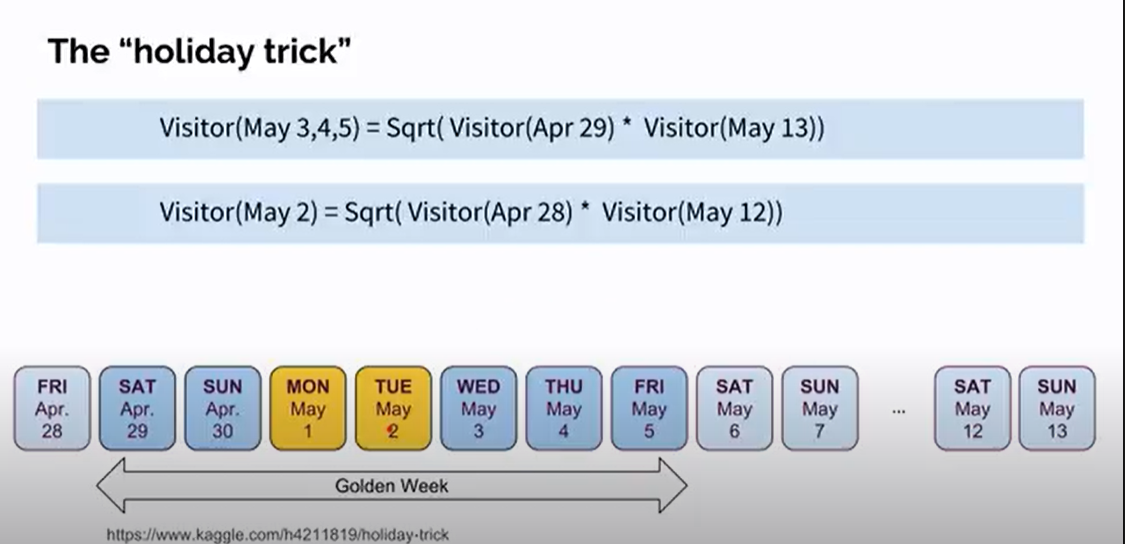

In [ ]:
def holiday_trick(submission):
    
    sub = submission.copy()
    sub['date'] = pd.to_datetime(sub.id.str[21:])
    sub['golden_week_visitors'] = np.nan
    # geometric mean
    sub.loc[sub.date == '2017-05-03', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-29','visitors'].values\
                                                                               * sub.loc[sub.date=='2017-5-13','visitors'].values))
    sub.loc[sub.date == '2017-05-04', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-29','visitors'].values\
                                                                               * sub.loc[sub.date=='2017-5-13','visitors'].values))
    sub.loc[sub.date == '2017-05-05', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-29','visitors'].values\
                                                                               * sub.loc[sub.date=='2017-5-13','visitors'].values))
    sub.loc[sub.date == '2017-05-02', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-28','visitors'].values\
                                                                               * sub.loc[sub.date=='2017-5-12','visitors'].values))
    
    # replace the predicted visitors
    sub.loc[sub.date == '2017-05-03', 'visitors'] = sub.loc[sub.date == '2017-05-03', 'golden_week_visitors']
    sub.loc[sub.date == '2017-05-04', 'visitors'] = sub.loc[sub.date == '2017-05-04', 'golden_week_visitors']
    sub.loc[sub.date == '2017-05-05', 'visitors'] = sub.loc[sub.date == '2017-05-05', 'golden_week_visitors']
    sub.loc[sub.date == '2017-05-02', 'visitors'] = sub.loc[sub.date == '2017-05-02', 'golden_week_visitors']
    
    return sub[['id', 'visitors']]

<h2>4. Bulding ML Models </h2>
<h3>Linear regression</h3>

In [ ]:
# hyperparameters
params = { 
           'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] 
         }

model = SGDRegressor()

# hyperparameters search
grid_search_cv = GridSearchCV(estimator=model,
                      param_grid=params,
                      n_jobs= 3,
                      cv= 4,
                      scoring=rmsle_scorer,
                      verbose=10,
                      return_train_score=True)

grid_search_cv.fit(X_tr_std, y_train.values.reshape(-1))

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   12.6s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done  26 out of  28 | elapsed:   25.5s remaining:    2.0s
[Parallel(n_jobs=3)]: Done  28 out of  28 | elapsed:   27.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(cal_rmsle, greater_is_better=False),
             verbose

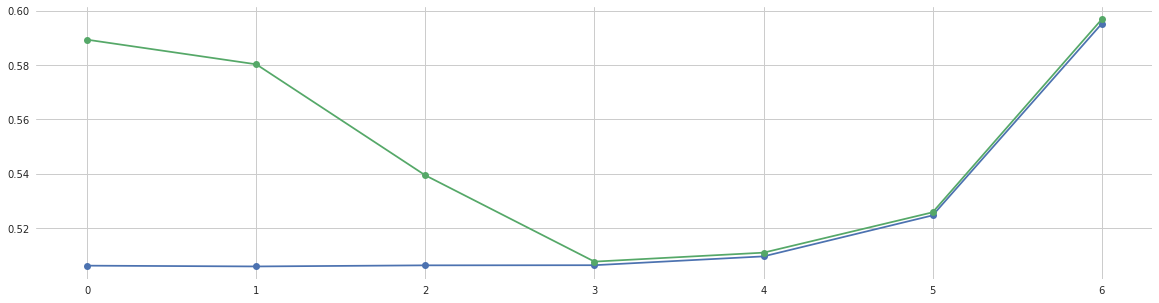

In [ ]:
params = grid_search_cv.cv_results_
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
plt.plot(range(len(alpha)), params['mean_train_score']*-1, label='Train RMSLE score',marker='o')
plt.plot(range(len(alpha)), params['mean_test_score']*-1, label='Test RMSLE score',marker='o')

In [ ]:
model = grid_search_cv.best_estimator_

model.fit(X_tr_std, y_train.values.reshape(-1))

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
y_tr_pred = model.predict(X_tr_std)
rmsle_train_val = cal_rmsle(y_train.values.reshape(-1),y_tr_pred)
print(f'Best Train RMSLE {rmsle_train_val}')
y_cv_pred = model.predict(X_val_std)
rmsle_cv_val = cal_rmsle(y_val.values.reshape(-1),y_cv_pred)
print(f'Best Test RMSLE {rmsle_cv_val}')

Best Train RMSLE 0.5068532288327322
Best Test RMSLE 0.5168747492844149


In [ ]:
y_test_pred = model.predict(X_test_std)
sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(y_test_pred)

In [ ]:
sample_submission_new=holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_LR.csv',index=False)

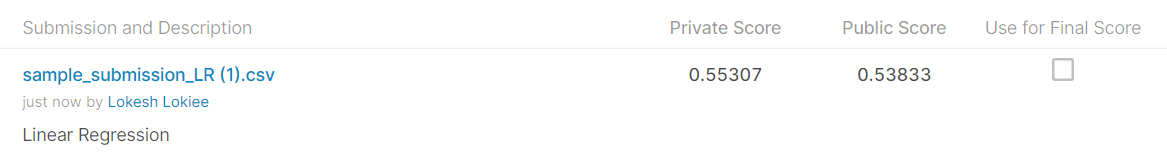

<h3> Random Forest Regressor </h3>

In [ ]:
rf_params = { 
              'n_estimators' : [5, 10, 50, 100, 250, 500], 
              'max_depth' : [1, 5, 10, 50, 100]
             }
rf_model = RandomForestRegressor(min_samples_split=200)

rf_random_cv = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    scoring=rmsle_scorer,
    cv=3,
    return_train_score=True,
    verbose=10,
    n_jobs=-1
)

rf_random_cv.fit(X_train,y_train.values.reshape(-1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=200,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                            

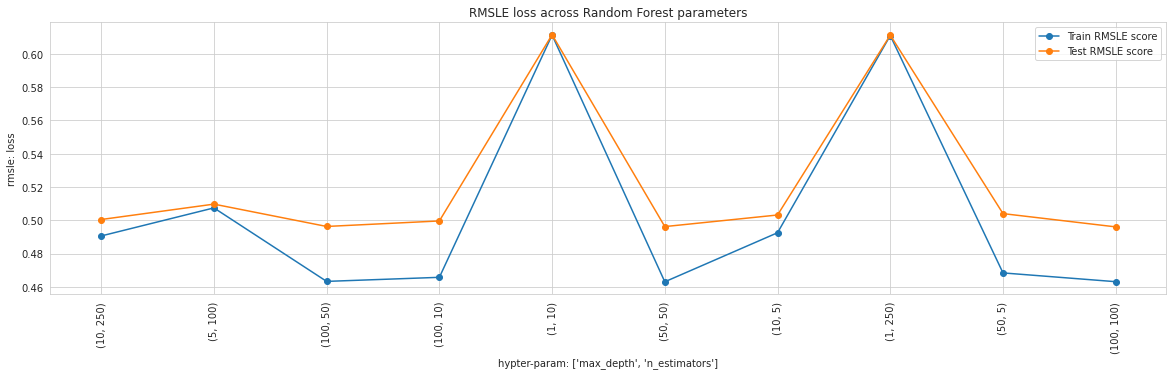

In [ ]:
params = rf_random_cv.cv_results_
hyperparms = [(i['max_depth'],i['n_estimators']) for i in params['params']]

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
plt.plot(range(len(hyperparms)), params['mean_train_score']*-1, label='Train RMSLE score',marker='o')
plt.plot(range(len(hyperparms)), params['mean_test_score']*-1, label='Test RMSLE score',marker='o')

plt.xticks(range(len(hyperparms)), labels = hyperparms, rotation=90)
plt.legend()
plt.xlabel("hypter-param: ['max_depth', 'n_estimators']")
plt.ylabel("rmsle: loss")
plt.title("RMSLE loss across Random Forest parameters")
plt.show()

In [ ]:
model = rf_random_cv.best_estimator_

model.fit(X_train, y_train.values.reshape(-1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=200, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_tr_pred = model.predict(X_train)
rmsle_train_val = cal_rmsle(y_train.values.reshape(-1),y_tr_pred)
print(f'Best Train RMSLE {rmsle_train_val}')
y_cv_pred = model.predict(X_val)
rmsle_cv_val = cal_rmsle(y_val.values.reshape(-1),y_cv_pred)
print(f'Best Test RMSLE {rmsle_cv_val}')

Best Train RMSLE 0.5045789119780888
Best Test RMSLE 0.5288919957420268


In [ ]:
y_test_pred = model.predict(X_test)
sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(y_test_pred)

In [ ]:
sample_submission_new=holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_RF.csv',index=False)

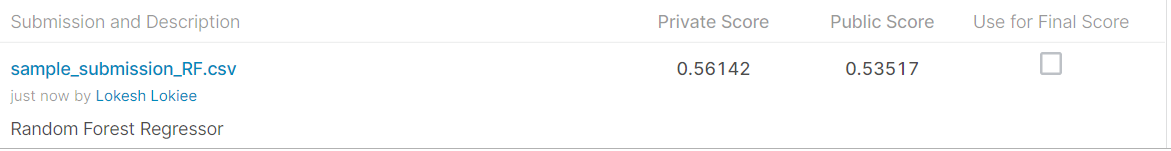

<h3>XGBoost Regressor</h3>

In [ ]:
param_grid = {
    "learning_rate": [0.001, 0.003, 0.01, 0.1],
    "colsample_bytree": [0.3, 0.4, 0.5],
    'min_child_weight' : [0.7, 0.8, 0.9, 1],
    'max_depth' : [2, 4, 8],
    'subsample' : [0.5, 0.6, 0.7]
}


xgboost = XGBRegressor(n_jobs=4)
xgb_random_search = RandomizedSearchCV(estimator=xgboost,
                     param_distributions=param_grid,
                     cv=3,
                     return_train_score=True,
                     n_jobs=-1,
                     verbose=1-0,
                     scoring=rmsle_scorer)

xgb_random_search.fit(X_train,y_train.values.reshape(-1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.2min finished


[16:21:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=4, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5],
                                        'learning_ra

In [ ]:
model = xgb_random_search.best_estimator_

model.fit(X_train, y_train.values.reshape(-1))

[16:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=0.8, missing=None, n_estimators=100,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [ ]:
y_tr_pred = model.predict(X_train)
rmsle_train_val = cal_rmsle(y_train.values.reshape(-1),y_tr_pred)
print(f'Best Train RMSLE {rmsle_train_val}')
y_cv_pred = model.predict(X_val)
rmsle_cv_val = cal_rmsle(y_val.values.reshape(-1),y_cv_pred)
print(f'Best Train RMSLE {rmsle_cv_val}')

Best Train RMSLE 1.0045789119780888
Best Train RMSLE 1.0088919957420268


In [ ]:
y_test_pred = model.predict(X_test)
sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(y_test_pred)

In [ ]:
sample_submission_new=holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_XGBoost.csv',index=False)

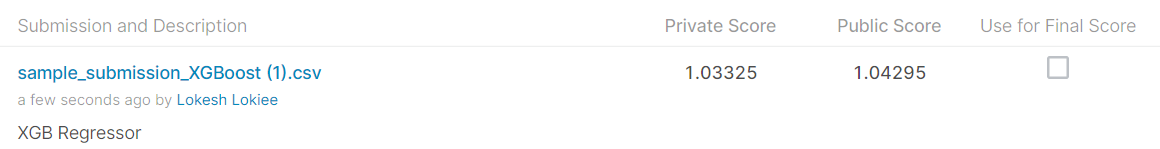

<h3>XGBoost Regressor</h3>

In [ ]:
# best parameters
xgbm_best_params = {'objective':'reg:squarederror', # objective for regression
              'eval_metric':'rmse', # root mean squared error
              'learning_rate':0.01, 
              'min_child_weight':0.8,
              'subsample':0.6,
              'colsample_bytree':0.5,
              'max_depth': 8}

# xgb.DMatrix
x_train_matrix = xgb.DMatrix(data=X_train, label=y_train)
x_val_matrix = xgb.DMatrix(data=X_val, label=y_val)

# training model
model = xgb.train(params=xgbm_best_params,
                 dtrain=x_train_matrix,
                 evals=[(x_train_matrix, 'train'), (x_val_matrix, 'test')],
                early_stopping_rounds=100, 
                 num_boost_round=5000)

[0]	train-rmse:2.41073	test-rmse:2.42241
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[1]	train-rmse:2.38773	test-rmse:2.39929
[2]	train-rmse:2.36496	test-rmse:2.37638
[3]	train-rmse:2.3424	test-rmse:2.35372
[4]	train-rmse:2.32009	test-rmse:2.33126
[5]	train-rmse:2.29798	test-rmse:2.30907
[6]	train-rmse:2.27612	test-rmse:2.28715
[7]	train-rmse:2.2545	test-rmse:2.2653
[8]	train-rmse:2.23312	test-rmse:2.24375
[9]	train-rmse:2.2119	test-rmse:2.22239
[10]	train-rmse:2.19097	test-rmse:2.20132
[11]	train-rmse:2.17024	test-rmse:2.18043
[12]	train-rmse:2.14978	test-rmse:2.15998
[13]	train-rmse:2.12947	test-rmse:2.13958
[14]	train-rmse:2.10937	test-rmse:2.11937
[15]	train-rmse:2.0895	test-rmse:2.0993
[16]	train-rmse:2.06983	test-rmse:2.07953
[17]	train-rmse:2.05038	test-rmse:2.05997
[18]	train-rmse:2.03117	test-rmse:2.04076
[19]	train-rmse:2.01212	test-rmse:2.02156
[20]	train-rmse:1.99327	test-rms

In [ ]:
xgbmr_val_predictions = model.predict(x_val_matrix)

val_rmsle = cal_rmsle(y_val.values, xgbmr_val_predictions)
print(f'RMSLE score: lightboost-regression: {val_rmsle}' )

RMSLE score: lightboost-regression: 0.4782038837418226


In [ ]:
x_train_matrix = xgb.DMatrix(data=pd.concat([X_train, X_val]), label=pd.concat([y_train, y_val]))
x_test_matrix = xgb.DMatrix(data=X_test)

# training model
model = xgb.train(params=xgbm_best_params, dtrain=x_train_matrix, num_boost_round=4028)

In [ ]:
xgbmr_tr_predictions = model.predict(x_train_matrix)
train_rmsle = cal_rmsle(pd.concat([y_train, y_val]).values, xgbmr_tr_predictions)
print(f'RMSLE score: lightboost-regression: {train_rmsle}' )

RMSLE score: lightboost-regression: 0.40780576368240834


In [ ]:
xgb_test_predictions = model.predict(x_test_matrix)

sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(xgb_test_predictions)

#Save Files
sample_submission_new = holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_XGB.csv',index=False)

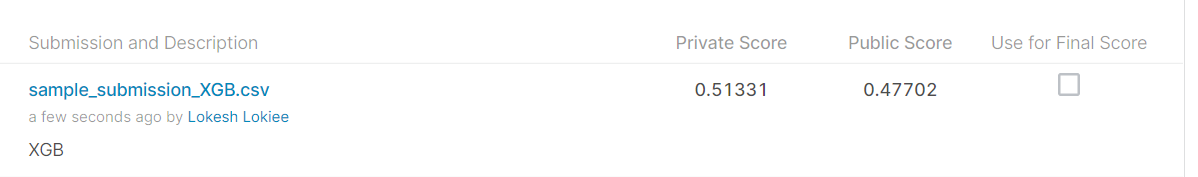

<h3>ML Models Summary</h3>

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Private Score", "Public Score"]

x.add_row(["Linear Regression", 0.55307, 0.53833])
x.add_row(["Random Forest Regressor", 0.56142, 0.53517])
x.add_row(["XGB Regressor", 0.53263, 0.50481])
x.add_row(["Light GBM", 0.51331, 0.47702])

print(x)

+-------------------------+---------------+--------------+
|          Model          | Private Score | Public Score |
+-------------------------+---------------+--------------+
|    Linear Regression    |    0.55307    |   0.53833    |
| Random Forest Regressor |    0.56142    |   0.53517    |
|      XGB Regressor      |    0.53263    |   0.50481    |
|        Light GBM        |    0.51331    |   0.47702    |
+-------------------------+---------------+--------------+


<h3>5. Using Deep Learning Models</h3>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,LeakyReLU,Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
def dl_rmsle_ae(y_true, y_pred):
  '''Calculate RMSLE onn predicted tensor'''
  y_pred = tf.math.expm1(y_pred)
  y_true = tf.math.expm1(y_true)

  #Return RMSLE
  return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

In [ ]:
tf.keras.backend.clear_session()

# initializer = tf.keras.initializers.HeNormal()
input_size = X_tr_std.shape[1]
hidden_size = 98
code_size = 32

x = Input(shape=(input_size,))

###Level-1
hidden_1 = Dense(hidden_size, activation='relu')(x)
d1 = BatchNormalization()(hidden_1)
lr1 = LeakyReLU()(d1)
###Level-2
hidden_2 = Dense(64, activation='relu')(lr1)
d2 = BatchNormalization()(hidden_2)
lr2= LeakyReLU()(d2)

###Bottleneck
h = Dense(code_size, activation='relu')(lr2)

##Level-4
hidden_3 = Dense(64, activation='relu')(h)
d3 = BatchNormalization()(hidden_3)
lr3 = LeakyReLU()(d3)
##Level-4=5
hidden_4 = Dense(hidden_size, activation='relu')(lr3)
d4 = BatchNormalization()(hidden_4)
lr4 = LeakyReLU()(d4)

##Output
r = Dense(input_size, activation='relu')(lr4)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=dl_rmsle_ae)

#################
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125)]             0         
_________________________________________________________________
dense (Dense)                (None, 98)                12348     
_________________________________________________________________
batch_normalization (BatchNo (None, 98)                392       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 98)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6336      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0     

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_dl_rmsle_ae', factor=0.1, patience=10, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dl_rmsle_ae',patience=5, mode='min')

epochs = 50
batch_size = 32

history = autoencoder.fit(X_tr_std, y_train.values.reshape(-1), batch_size=batch_size, epochs=epochs, verbose=1, 
                          validation_data=(X_val_std, y_val.values.reshape(-1)), callbacks=[reduce_lr,early_stop])

Epoch 1/50
7386/7386 [==============================] - 29s 4ms/step - loss: 0.3669 - dl_rmsle_ae: 0.5730 - val_loss: 0.2921 - val_dl_rmsle_ae: 0.5212
Epoch 2/50
7386/7386 [==============================] - 28s 4ms/step - loss: 0.2702 - dl_rmsle_ae: 0.5125 - val_loss: 0.2554 - val_dl_rmsle_ae: 0.4888
Epoch 3/50
7386/7386 [==============================] - 27s 4ms/step - loss: 0.2600 - dl_rmsle_ae: 0.5027 - val_loss: 0.2630 - val_dl_rmsle_ae: 0.4963
Epoch 4/50
7386/7386 [==============================] - 26s 4ms/step - loss: 0.2533 - dl_rmsle_ae: 0.4960 - val_loss: 0.2625 - val_dl_rmsle_ae: 0.4948
Epoch 5/50
7386/7386 [==============================] - 26s 3ms/step - loss: 0.2479 - dl_rmsle_ae: 0.4909 - val_loss: 0.2583 - val_dl_rmsle_ae: 0.4919
Epoch 6/50
7386/7386 [==============================] - 26s 4ms/step - loss: 0.2438 - dl_rmsle_ae: 0.4868 - val_loss: 0.2608 - val_dl_rmsle_ae: 0.4935
Epoch 7/50
7386/7386 [==============================] - 27s 4ms/step - loss: 0.2402 - dl_rmsle

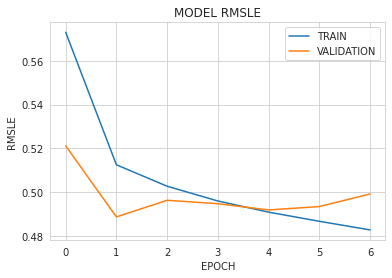

In [ ]:
plt.plot(history.history['dl_rmsle_ae'])
plt.plot(history.history['val_dl_rmsle_ae'])
plt.title('MODEL RMSLE')
plt.ylabel('RMSLE')
plt.xlabel('EPOCH')
plt.legend(['TRAIN', 'VALIDATION'], loc='upper right')
plt.show()

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=x, outputs=h)
# save the encoder to file
encoder.save('./drive/MyDrive/gdrive/encoder.h5')

In [ ]:
encoder = load_model('./drive/MyDrive/gdrive/encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_tr_std)
# encode the Validation data
X_val_encode = encoder.predict(X_val_std)
# encode the Test data
X_test_encode = encoder.predict(X_test_std)

<h3>Liner Regression with Autoencoders</h3>

In [ ]:
# hyperparameters
params = { 'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] }

model = SGDRegressor()

# hyperparameters search
grid_search_cv = GridSearchCV(estimator=model,
                      param_grid=params,
                      n_jobs= 3,
                      cv= 4,
                      scoring=rmsle_scorer,
                      verbose=10,
                      return_train_score=True)

grid_search_cv.fit(X_train_encode, y_train.values.reshape(-1))

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done  26 out of  28 | elapsed:   12.1s remaining:    0.9s
[Parallel(n_jobs=3)]: Done  28 out of  28 | elapsed:   12.5s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(cal_rmsle, greater_is_better=False),
             verbose

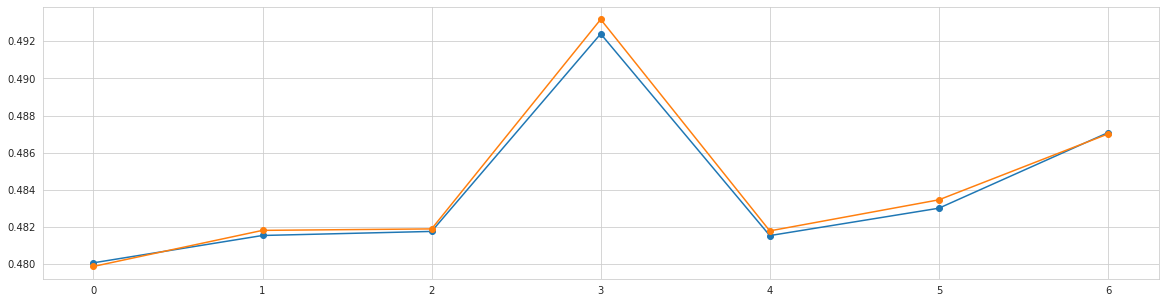

In [ ]:
params = grid_search_cv.cv_results_
alpha = [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
plt.plot(range(len(alpha)), params['mean_train_score']*-1, label='Train RMSLE score',marker='o')
plt.plot(range(len(alpha)), params['mean_test_score']*-1, label='Test RMSLE score',marker='o')

In [ ]:
model = grid_search_cv.best_estimator_

model.fit(X_train_encode, y_train.values.reshape(-1))

y_tr_pred = model.predict(X_train_encode)
rmsle_train_val = cal_rmsle(y_train.values.reshape(-1),y_tr_pred)
print(f'Best Train RMSLE {rmsle_train_val}')
y_cv_pred = model.predict(X_val_encode)
rmsle_cv_val = cal_rmsle(y_val.values.reshape(-1),y_cv_pred)
print(f'Best Train RMSLE {rmsle_cv_val}')

Best Train RMSLE 0.48095440033601433
Best Train RMSLE 0.5198602539406526


In [ ]:
y_test_pred = model.predict(X_test_encode)
sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(y_test_pred)

In [ ]:
#Save Files
sample_submission_new = holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_AutoEncoders_LR.csv',index=False)

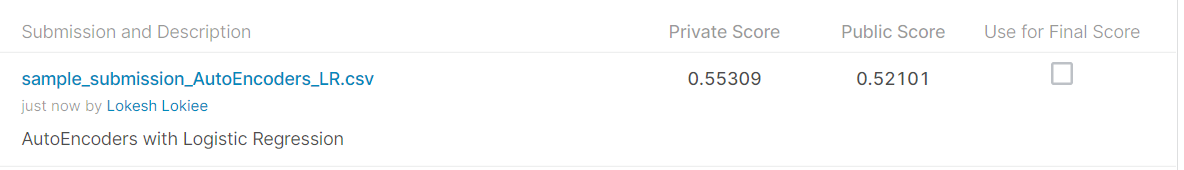

<h3>Random Forest Regressor with Autoencoders</h3>

In [ ]:
rf_params = { 
              'n_estimators' : [5, 10, 50, 100, 250, 500], 
              'max_depth' : [1, 5, 10, 50, 100]
             }
rf_model = RandomForestRegressor(min_samples_split=200)

rf_random_cv = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    scoring=rmsle_scorer,
    cv=3,
    return_train_score=True,
    verbose=10,
    n_jobs=-1
)

rf_random_cv.fit(X_train_encode,y_train.values.reshape(-1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 153.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=200,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                            

In [ ]:
model = rf_random_cv.best_estimator_

model.fit(X_train_encode, y_train.values.reshape(-1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=200, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_tr_pred = model.predict(X_train_encode)
rmsle_train_val = cal_rmsle(y_train.values.reshape(-1),y_tr_pred)
print(f'Best Train RMSLE {rmsle_train_val}')
y_cv_pred = model.predict(X_val_encode)
rmsle_cv_val = cal_rmsle(y_val.values.reshape(-1),y_cv_pred)
print(f'Best Test RMSLE {rmsle_cv_val}')

Best Train RMSLE 0.4649761786053603
Best Test RMSLE 0.5090987921745221


In [ ]:
y_test_pred = model.predict(X_test_encode)
sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(y_test_pred)

In [ ]:
#Save Files
sample_submission_new = holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_AutoEncoders_RF.csv',index=False)

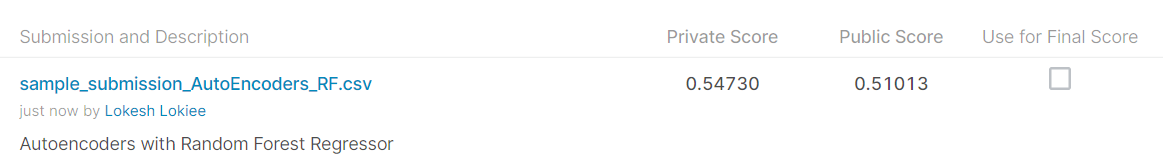

<h3>XGB Regressor</h3>

In [ ]:
# best parameters
xgbm_best_params = {'objective':'reg:squarederror', # objective for regression
              'eval_metric':'rmse', # root mean squared error
              'learning_rate':0.01, 
              'min_child_weight':0.8,
              'subsample':0.7,
              'colsample_bytree':0.5,
              'max_depth': 8}

# xgb.DMatrix
x_train_matrix = xgb.DMatrix(data=X_train_encode, label=y_train)
x_val_matrix = xgb.DMatrix(data=X_val_encode, label=y_val)

# training model
model = xgb.train(params=xgbm_best_params,
                 dtrain=x_train_matrix,
                 evals=[(x_train_matrix, 'train'), (x_val_matrix, 'test')],
                early_stopping_rounds=100, 
                 num_boost_round=5000)

[0]	train-rmse:2.41065	test-rmse:2.42268
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[1]	train-rmse:2.38751	test-rmse:2.39969
[2]	train-rmse:2.36462	test-rmse:2.37703
[3]	train-rmse:2.34199	test-rmse:2.3547
[4]	train-rmse:2.31955	test-rmse:2.33242
[5]	train-rmse:2.29736	test-rmse:2.31043
[6]	train-rmse:2.27536	test-rmse:2.28857
[7]	train-rmse:2.25362	test-rmse:2.26695
[8]	train-rmse:2.2321	test-rmse:2.24559
[9]	train-rmse:2.21082	test-rmse:2.22443
[10]	train-rmse:2.18974	test-rmse:2.20351
[11]	train-rmse:2.16891	test-rmse:2.18291
[12]	train-rmse:2.1483	test-rmse:2.16254
[13]	train-rmse:2.12786	test-rmse:2.14225
[14]	train-rmse:2.10764	test-rmse:2.12216
[15]	train-rmse:2.08765	test-rmse:2.10234
[16]	train-rmse:2.06789	test-rmse:2.08282
[17]	train-rmse:2.0483	test-rmse:2.06339
[18]	train-rmse:2.02895	test-rmse:2.04424
[19]	train-rmse:2.00977	test-rmse:2.02524
[20]	train-rmse:1.99082	test-r

In [ ]:
xgbmr_val_predictions = model.predict(x_val_matrix)

val_rmsle = cal_rmsle(y_val.values, xgbmr_val_predictions)
print(f'RMSLE score: lightboost-regression: {val_rmsle}' )

RMSLE score: lightboost-regression: 0.5113254343372166


In [ ]:
X_train_encode

array([[1.6772065, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.6602566, 1.4234233, ..., 1.2919415, 2.59     ,
        1.2317342],
       [0.       , 0.       , 2.6523356, ..., 0.       , 1.0632694,
        1.1742673],
       ...,
       [0.       , 2.2176828, 1.7649553, ..., 0.       , 0.       ,
        2.4850955],
       [0.       , 1.7781892, 2.5536618, ..., 0.       , 0.1223906,
        2.5457115],
       [0.       , 2.1063364, 2.7460256, ..., 0.       , 1.0411634,
        1.8679171]], dtype=float32)

In [ ]:
x_train_matrix = xgb.DMatrix(data=np.concatenate([X_train_encode, X_val_encode]), label=pd.concat([y_train, y_val]))
x_test_matrix = xgb.DMatrix(data=X_test_encode)

# training model
model = xgb.train(params=xgbm_best_params, dtrain=x_train_matrix, num_boost_round=638)

In [ ]:
xgbmr_tr_predictions = model.predict(x_train_matrix)
train_rmsle = cal_rmsle(pd.concat([y_train, y_val]).values, xgbmr_tr_predictions)
print(f'RMSLE score: lightboost-regression: {train_rmsle}' )

RMSLE score: lightboost-regression: 0.45926203981966657


In [ ]:
xgb_test_predictions = model.predict(x_test_matrix)

sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(xgb_test_predictions)

#Save Files
sample_submission_new = holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_AutoEncoders_XGB.csv',index=False)

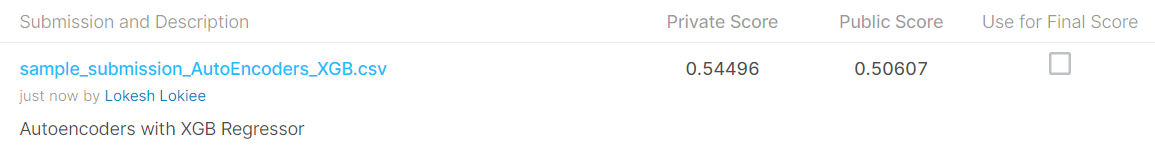

<h3> LSTM </h3>

In [ ]:
from tensorflow.keras.layers import LSTM
tf.config.run_functions_eagerly(True)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# reshape input
x_tr_lstm = X_tr_std.reshape(X_tr_std.shape[0], 1, X_tr_std.shape[1])
x_val_lstm = X_val_std.reshape(X_val_std.shape[0], 1, X_val_std.shape[1])
x_test_lstm = X_test_std.reshape(X_test_std.shape[0], 1, X_test_std.shape[1])

print("x_train: ", x_tr_lstm.shape)
print("x_val: ", x_val_lstm.shape)
print("x_test: ", x_test_lstm.shape)

x_train:  (236338, 1, 125)
x_val:  (15770, 1, 125)
x_test:  (32019, 1, 125)


In [ ]:
def dl_rmsle(y_true, y_pred):
    """
    This function will calculate the RMSLE score given the predicition and true values
    """

    # get exp of log predictions
    y_pred = tf.math.expm1(y_pred)
    y_true = tf.math.expm1(y_true)

    # calculate the rmsle
    # formula 
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

dl_rmsle_scorer = make_scorer(score_func=dl_rmsle, greater_is_better=False)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_tr_lstm.shape[1], x_tr_lstm.shape[2])))
model.add(LSTM(units=30, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=dl_rmsle)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             35200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             9720      
_________________________________________________________________
dense (Dense)                (None, 1, 1)              31        
Total params: 44,951
Trainable params: 44,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_dl_rmsle', factor=0.1, patience=10, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dl_rmsle',patience=5, mode='min')

epochs = 15
batch_size = 64

model.fit(x_tr_lstm, y_train.values.reshape(-1),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(x_val_lstm, y_val.values.reshape(-1)), callbacks=[reduce_lr, early_stop] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/15
3693/3693 [==============================] - 109s 29ms/step - loss: 0.3784 - dl_rmsle: 0.5558 - val_loss: 0.2671 - val_dl_rmsle: 0.5052
Epoch 2/15
3693/3693 [==============================] - 107s 29ms/step - loss: 0.2457 - dl_rmsle: 0.4919 - val_loss: 0.2691 - val_dl_rmsle: 0.5069
Epoch 3/15
3693/3693 [==============================] - 108s 29ms/step - loss: 0.2393 - dl_rmsle: 0.4855 - val_loss: 0.2600 - val_dl_rmsle: 0.4986
Epoch 4/15
3693/3693 [==============================] - 108s 29ms/step - loss: 0.2350 - dl_rmsle: 0.4812 - val_loss: 0.2623 - val_dl_rmsle: 0.5015
Epoch 5/15
3693/3693 [==============================] - 103s 28ms/step - loss: 0.2320 - dl_rmsle: 0.4780 - val_loss: 0.2581 - val_dl_rmsle: 0.4973
Epoch 6/15
3693/3693 [==============================] - 103s 28ms/step - loss: 0.2293 - dl_rmsle: 0.4753 - val_loss: 0.2616 - val_dl_rmsle: 0.4999
Epoch 7/15
3693/3693 [==============================] - 102s 28ms/step - loss: 0.2273 - dl_rmsle: 0.4731 - val_loss: 0

In [ ]:
y_cv_pred = model.predict(x_val_lstm)
rmsle_cv_val = cal_rmsle(y_val.values.reshape(-1),y_cv_pred)
print(f'Best Train RMSLE {rmsle_cv_val}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Best Train RMSLE 1.072922885336004


In [ ]:
op=[]
for i in lstm_test_predictions:
  op.append(i[0][0])

In [ ]:
lstm_test_predictions = model.predict(x_test_lstm)

op=[]
for i in lstm_test_predictions:
  op.append(i[0][0])

sample_submission = pd.read_csv("./drive/MyDrive/gdrive/RecruitResturantCaseStudy/data/sample_submission.csv")
sample_submission.visitors = np.expm1(op)

#Save Files
sample_submission_new = holiday_trick(sample_submission)
sample_submission_new.to_csv('./drive/MyDrive/gdrive/RecruitResturantCaseStudy/SubmissionFiles/sample_submission_LSTM.csv',index=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


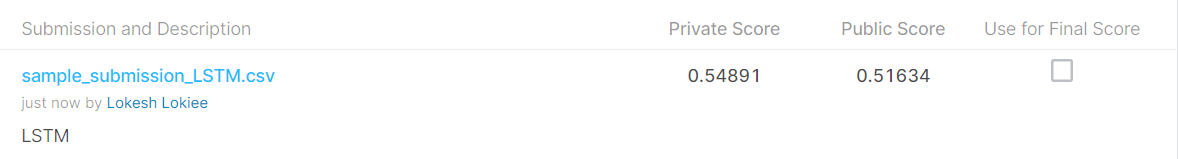

<h3>Summary</h3>

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Private Score", "Public Score"]

x.add_row(["Linear Regression", 0.55307, 0.53833])
x.add_row(["Random Forest Regressor", 0.56142, 0.53517])
x.add_row(["XGB Regressor sklearn", 1.03325, 1.04295])
x.add_row(["XGB using xgboost", 0.51331, 0.47702])
x.add_row(["Auto encoders with Linear Regression", 0.55309, 0.52101])
x.add_row(["Auto encoders with Random Forest", 0.54730, 0.51013])
x.add_row(["Auto encoders with XGB", 0.54496, 0.50607])
x.add_row(["LSTM", 0.54891, 0.51634])

print(x)

+--------------------------------------+---------------+--------------+
|                Model                 | Private Score | Public Score |
+--------------------------------------+---------------+--------------+
|          Linear Regression           |    0.55307    |   0.53833    |
|       Random Forest Regressor        |    0.56142    |   0.53517    |
|        XGB Regressor sklearn         |    1.03325    |   1.04295    |
|          XGB using xgboost           |    0.51331    |   0.47702    |
| Auto encoders with Linear Regression |    0.55309    |   0.52101    |
|   Auto encoders with Random Forest   |     0.5473    |   0.51013    |
|        Auto encoders with XGB        |    0.54496    |   0.50607    |
|                 LSTM                 |    0.54891    |   0.51634    |
+--------------------------------------+---------------+--------------+


XGB using xgboost package gave goor result with below scores</br>
</br>

Private Score: 0.51331</br>
Public Score: 0.47702 </br>
</br>
Both scores are in top 100